In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# cd /content/drive/My\ Drive/ShipDetection/

In [0]:
import os, shutil
import random
import csv
import cv2

train_imgs =[]
test_imgs = []

count =0
with open('/content/drive/My Drive/ShipDetection/original_data/train/train.csv','rt')as f:
  data = csv.reader(f)
  for row in data:
    img = row[0]
#     print(img)
#     count=count+1
    train_imgs.append(img)
    
random.shuffle(train_imgs)  # shuffle it randomly


In [0]:
print(len(test_imgs))

2680


In [0]:
#Import some packages to use
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [0]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = 150
ncolumns = 150
channels = 3  #change to 1 if you want to use grayscale image


#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        image_path = "/content/drive/My Drive//ShipDetection/train/images/" +  image
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        X.append(cv2.resize(img, (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        with open('/content/drive/My Drive/ShipDetection/train/train.csv','rt')as f:
          data = csv.reader(f)
          for row in data:
            if row[0] == image:
                label = row[1]
                
        #get the labels
        y.append(label)

    
    return X, y

In [0]:
#get the train and label data
X, y = read_and_process_image(train_imgs)

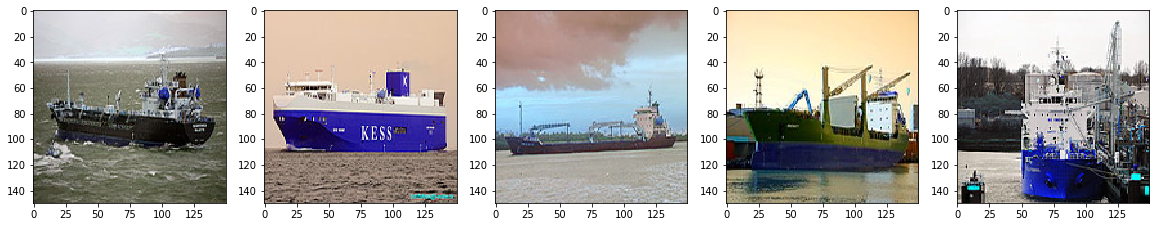

In [0]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels ships')

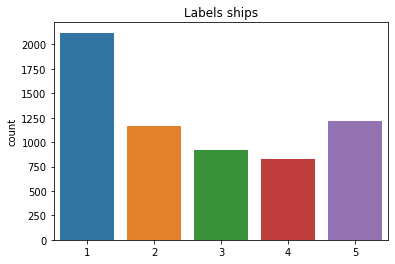

In [0]:
import gc
# del train_imgs
# gc.collect()
#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Labels ships')

In [0]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (6252, 150, 150, 3)
Shape of labels is: (6252,)


In [0]:
y

array(['5', '3', '1', ..., '4', '2', '5'], dtype='<U1')

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.


In [0]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

In [0]:
#clear memory
# del X
# del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

Create model

In [0]:

from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [0]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:

from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [0]:
#Lets see our model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 57,877,221
Trainable params: 57,816,677
Non-trainable params: 60,544
_________________________________________________________________


In [0]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [0]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
from keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [0]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [0]:

#Create the image generators
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [0]:
#The training part
#We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=50,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/50
156/156 [==============================] - 39s 249ms/step - loss: 1.4078 - acc: 0.4165 - val_loss: 1.8138 - val_acc: 0.4960
Epoch 2/50
156/156 [==============================] - 26s 169ms/step - loss: 1.1128 - acc: 0.5646 - val_loss: 1.9461 - val_acc: 0.5455
Epoch 3/50
156/156 [==============================] - 26s 167ms/step - loss: 1.0222 - acc: 0.6024 - val_loss: 1.3342 - val_acc: 0.6686
Epoch 4/50
156/156 [==============================] - 27s 170ms/step - loss: 0.9658 - acc: 0.6304 - val_loss: 1.4266 - val_acc: 0.6284
Epoch 5/50
156/156 [==============================] - 26s 167ms/step - loss: 0.9374 - acc: 0.6459 - val_loss: 1.1653 - val_acc: 0.6694
Epoch 6/50
156/156 [==============================] - 26s 167ms/step - loss: 0.9150 - acc: 0.6510 - val_loss: 1.3938 - val_acc: 0.6620
Epoch 7/50
156/156 [==============================] - 26s 166ms/step - loss: 0.8921 - acc: 0.6597 - val_loss: 1.5538 - val_acc: 0.6481
Epoch 8/50
156/156 [==============================] - 2

In [0]:
#Save the model
model.save_weights('/content/drive/My Drive/ShipDetection/model_wieghts.h5')
model.save('/content/drive/My Drive/ShipDetection/model_keras.h5')

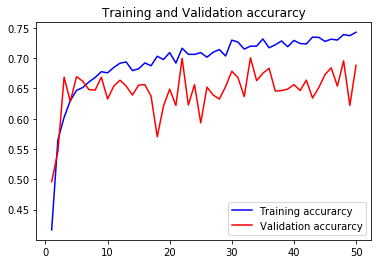

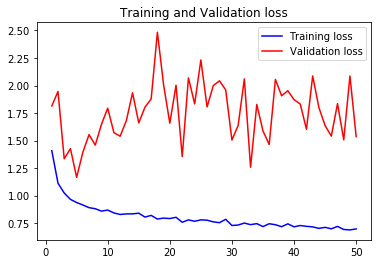

In [0]:
#lets plot the train and val curve
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [0]:

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

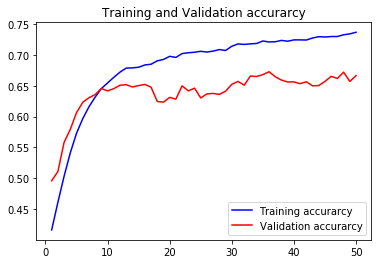

In [0]:
#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

In [0]:
len(test_imgs)

2680

In [0]:
import matplotlib.pyplot as plt
import csv
test_imgs = []
with open('/content/drive/My Drive/ShipDetection/test.csv','rt')as f:
  data = csv.reader(f)
  for row in data:
    img = row[0]
#     print(img)
#     count=count+1
    test_imgs.append(img)

In [0]:
# test_imgs

In [0]:
nrows = 150
ncolumns = 150
channels = 3

def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        image_path = "/content/drive/My Drive/ShipDetection/train/images/" +  image
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        X.append(cv2.resize(img, (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels

    
    return X, y

In [0]:
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#Now lets predict on the first 10 Images of the test set
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/ShipDetection/models_50epochs/model_keras.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


[[3.5899614e-08 9.9999499e-01 2.3085105e-14 1.4417766e-11 5.0241938e-06]]
1
['1']
[[1.0520843e-12 2.1107828e-15 8.8790954e-13 1.0000000e+00 1.5409894e-11]]
3
['1', '3']
[[1.02424165e-05 1.00329562e-05 9.20393086e-06 9.99827087e-01
  1.43510362e-04]]
3
['1', '3', '3']
[[1.13633569e-05 9.99975085e-01 2.84720544e-13 4.93452432e-11
  1.36024655e-05]]
1
['1', '3', '3', '1']
[[1.7006528e-10 3.0333047e-09 5.5539989e-10 1.0000000e+00 2.2358082e-09]]
3
['1', '3', '3', '1', '3']
[[6.5318856e-04 9.9783379e-01 8.5090365e-11 2.2255567e-11 1.5130880e-03]]
1
['1', '3', '3', '1', '3', '1']
[[6.4289816e-07 4.8712318e-10 7.5261287e-06 9.9997795e-01 1.3885243e-05]]
3
['1', '3', '3', '1', '3', '1', '3']
[[6.2000277e-07 2.8995407e-13 2.7093148e-07 9.9999905e-01 1.6064992e-07]]
3
['1', '3', '3', '1', '3', '1', '3', '3']
[[2.3782547e-11 6.0264255e-10 2.5379319e-05 9.9997461e-01 2.2092143e-10]]
3
['1', '3', '3', '1', '3', '1', '3', '3', '3']
[[2.6456481e-01 2.7694307e-07 1.0977966e-03 1.9545605e-07 7.3433691e

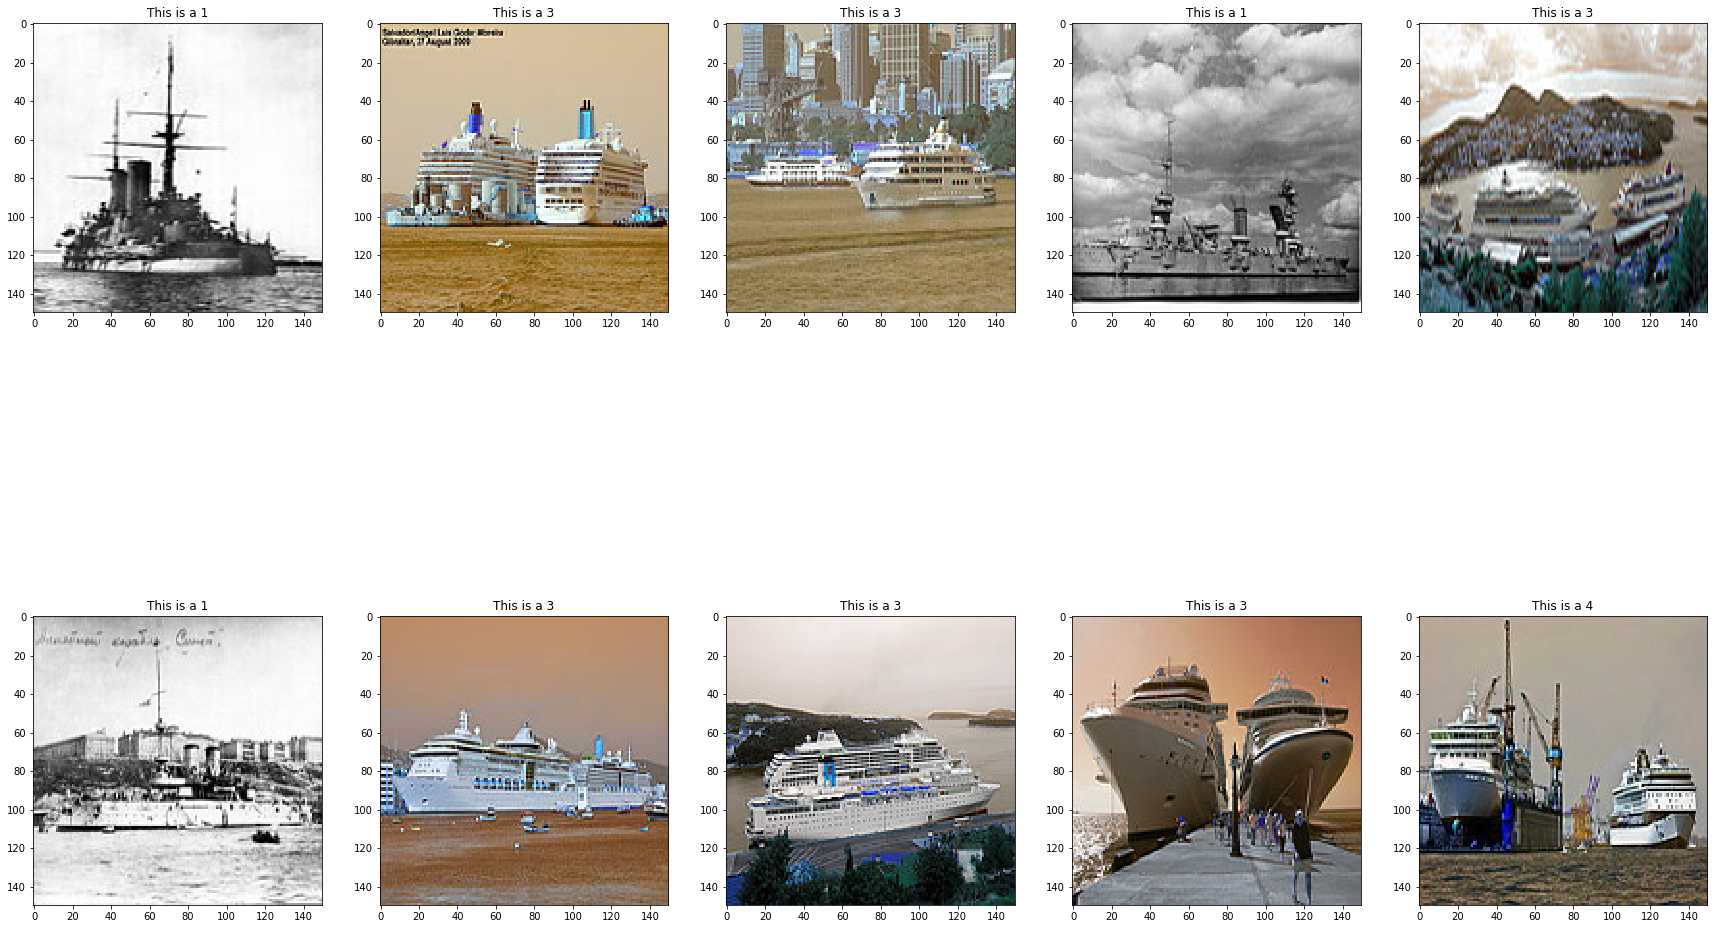

In [0]:
i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
#     print(pred)
    pred_label = np.argmax(pred)
#     print(pred_label)
    text_labels.append(str(pred_label))
    print(text_labels)
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()
